In [1]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
states = pd.read_excel("./messy_data/states.xlsx")
states.drop(states.index[states.Abbreviation == "DC"], inplace=True)
states.columns = ["Jurisdiction", "Jurisdiction Abbreviation"]
states = states.append({"Jurisdiction" : "Federal", "Jurisdiction Abbreviation" : "FED"}, ignore_index=True)

In [3]:
malePrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Male", header=9, nrows=54).dropna(1, "all").dropna(0)
femalePrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Female", header=9, nrows=54).dropna(1, "all").dropna(0)
totalPrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Total", header=9, nrows=54).dropna(1, "all").dropna(0)

In [4]:
def cleanAndMeltPopulationTable(table, states):
    
    # add DC data to Federal, and delete it
    table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] = table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] + table.loc[table.Jurisdiction == "District of Columbia"].iloc[:, 1:].replace("--", 0)
    table.drop(table.index[table.Jurisdiction == "District of Columbia"], inplace=True)
    
    meltedTable = table.melt(id_vars = "Jurisdiction", var_name = "Year", value_name = "Population")
    meltedTable.Year = meltedTable.Year.astype(int)
    
    table = states.merge(table, on="Jurisdiction")
    meltedTable = states.merge(meltedTable, on="Jurisdiction")
    
    return table, meltedTable

In [5]:
malePrisonerPopulation, meltedMalePrisonerPopulation = cleanAndMeltPopulationTable(malePrisonerPopulation, states)
femalePrisonerPopulation, meltedFemalePrisonerPopulation  = cleanAndMeltPopulationTable(femalePrisonerPopulation, states)
totalPrisonerPopulation, meltedTotalPrisonerPopulation = cleanAndMeltPopulationTable(totalPrisonerPopulation, states)

/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [6]:
def predictStates(table):
    
    jurisdictions = table.Jurisdiction.unique()

    prediction = [None for i in range(len(jurisdictions))]
    for i, j in enumerate(jurisdictions):
    
        data_1state = table.query('Jurisdiction == "' + j + '"')
        data_1state = data_1state[['Year', 'Population']]
        years = data_1state.Year
        data_1state.columns = ['ds', 'y']
        data_1state.ds = pd.to_datetime(data_1state.ds, format='%Y')
        data_1state.ds = data_1state.ds + pd.tseries.offsets.YearEnd()

        model = Prophet(yearly_seasonality=False,changepoint_prior_scale=0.1,changepoint_range=1)
        model.fit(data_1state)
    
        futureYears = model.make_future_dataframe(periods=34, freq="Y")
        forecast = model.predict(futureYears)
        forecast = forecast.iloc[:, :4]
    
        forecast.columns = ["Year", "Population", "Lower", "Upper"]
        forecast.Year = forecast.Year.dt.year
        forecast['Predicted'] = ~ np.isin(forecast.Year, years)
#         forecast.Population[~ forecast.Predicted] = data_1state.y
        forecast['Jurisdiction'] = j
        forecast['Jurisdiction Abbreviation'] = states['Jurisdiction Abbreviation'][states.Jurisdiction == j].iloc[0]

        prediction[i] = forecast

    prediction = pd.concat(prediction)
    prediction = prediction[['Jurisdiction', 'Jurisdiction Abbreviation', 'Year', 'Population', 'Lower', 'Upper', 'Predicted']]
    
    return prediction

In [7]:
predictedMalePrisonerPopulation = predictStates(meltedMalePrisonerPopulation)
predictedFemalePrisonerPopulation = predictStates(meltedFemalePrisonerPopulation)
predictedTotalPrisonerPopulation = predictStates(meltedTotalPrisonerPopulation)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [8]:
regions = pd.read_excel("./messy_data/state_region.xlsx")
regions.drop(regions.index[regions.State == "District of Columbia"], inplace=True)

In [9]:
def aggregateRegionalPopulationSum(table, regions):
    
    table = regions.merge(table, left_on="State", right_on="Jurisdiction", how="right")
    temp_index = table["Jurisdiction"] == "Federal"
    table.loc[temp_index, "Region"] = "Federal"
    table.loc[temp_index, "Division"] = "Federal"
    
    regionSum = table.groupby(["Year", "Region"]).Population.sum()
    divisionSum = table.groupby(["Year", "Region", "Division"]).Population.sum()
    
    return regionSum, divisionSum

In [10]:
malePrisonerPopulationRegionSum, malePrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(meltedMalePrisonerPopulation, regions)
femalePrisonerPopulationRegionSum, femalePrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(meltedFemalePrisonerPopulation, regions)
totalPrisonerPopulationRegionSum, totalPrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(meltedTotalPrisonerPopulation, regions)

In [11]:
def predictAreas(table):
    
    indexes = table.index.names
    areaType = 'Division' if 'Division' in indexes else "Region"
    areas = table.index.levels[indexes.index(areaType)]

    prediction = [None for i in range(len(areas))]
    for i, a in enumerate(areas):
    
        if areaType == 'Division':
            data_1area = table[:, :, a]
            region = data_1area.index.get_level_values(1).unique()[0]
            data_1area = data_1area.reset_index(level=1, drop=True)
        else:
            data_1area = table[:, a]
        data_1area = data_1area.reset_index()
        years = data_1area.Year
    
        data_1area.columns = ['ds', 'y']
        data_1area.ds =  pd.to_datetime(data_1area.ds, format='%Y')
        data_1area.ds = data_1area.ds + pd.tseries.offsets.YearEnd()
    
        model = Prophet(yearly_seasonality=False,changepoint_prior_scale=0.1,changepoint_range=1)
        model.fit(data_1area)
    
        futureYears = model.make_future_dataframe(periods=34, freq="Y")
        forecast = model.predict(futureYears)
        forecast = forecast.iloc[:, :4]
    
        forecast.columns = ["Year", "Population", "Lower", "Upper"]
        forecast.Year = forecast.Year.dt.year
        forecast['Predicted'] = ~ np.isin(forecast.Year, years)
        forecast.Population[~ forecast.Predicted] = data_1area.y
        
        if areaType == 'Division':
            forecast['Region'] = region
            forecast['Division'] = a
        else:
            forecast['Region'] = a
    
        prediction[i] = forecast
    
    prediction = pd.concat(prediction)
    prediction = prediction[['Region', 'Division', 'Year', 'Population', 'Lower', 'Upper', 'Predicted']] if areaType == 'Division' else  prediction[['Region', 'Year', 'Population', 'Lower', 'Upper', 'Predicted']]
    
    return prediction

In [12]:
predictedMalePrisonerPopulationRegionSum = predictAreas(malePrisonerPopulationRegionSum)
predictedFemalePrisonerPopulationRegionSum = predictAreas(femalePrisonerPopulationRegionSum)
predictedTotalPrisonerPopulationRegionSum = predictAreas(totalPrisonerPopulationRegionSum)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

In [13]:
predictedMalePrisonerPopulationDivisionSum = predictAreas(malePrisonerPopulationDivisionSum)
predictedFemalePrisonerPopulationDivisionSum = predictAreas(femalePrisonerPopulationDivisionSum)
predictedTotalPrisonerPopulationDivisionSum = predictAreas(totalPrisonerPopulationDivisionSum)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overrid

In [27]:
def plotStates(table, gender):
    
    table = table.merge(regions, how='left', left_on='Jurisdiction',right_on='State')
    table = table.drop('State', axis=1)
    
    allRegions = regions.Region.unique()
    for r in allRegions:
        divisions = regions.Division[regions.Region == r].unique()
        for d in divisions:
            data_1division = table.loc[table.Division == d, :]
            
            plt.figure()
            
            states = data_1division.Jurisdiction.unique()
            colors = sns.color_palette('husl', n_colors=len(states))
            for i, s in enumerate(states):
                data_1state = data_1division.loc[data_1division.Jurisdiction == s, :]
                
                years_original = data_1state.Year[~ data_1state.Predicted]
                years_predicted = data_1state.Year[data_1state.Predicted]
                
                datapoint_original = data_1state.Population[~ data_1state.Predicted]
                datapoint_predicted = data_1state.Population[data_1state.Predicted]
                
                predictionUpper = data_1state.Upper[data_1state.Predicted]
                predictionLower = data_1state.Lower[data_1state.Predicted]
                
                plt.plot(data_1state.Year, data_1state.Population, color=colors[i],label=s)
                plt.plot(years_original, datapoint_original, marker='.',color=colors[i])
                plt.fill_between(years_predicted, predictionLower,predictionUpper, facecolor=colors[i],linewidth=0,alpha=0.25)
                
                
            plt.gca().set_ylim(bottom=0, auto=True)
            plt.xlim([1978, 2050])
                
            plt.xlabel('Year')
            plt.ylabel('Prisoner Population')
                
            plt.title(gender + ' Prisoner Population, ' + d + ' - ' + r)
                
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(states))
                

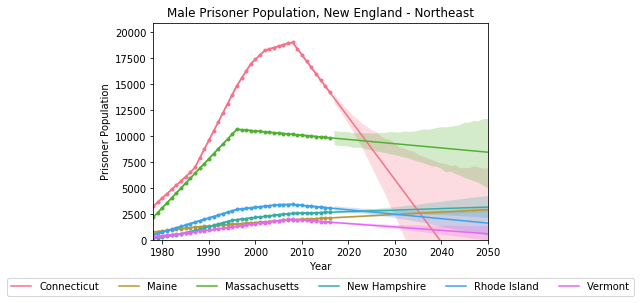

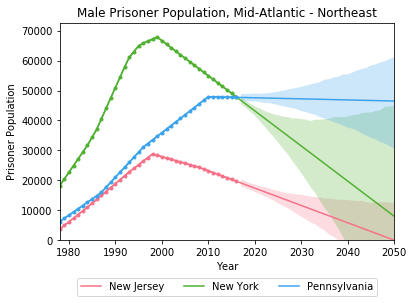

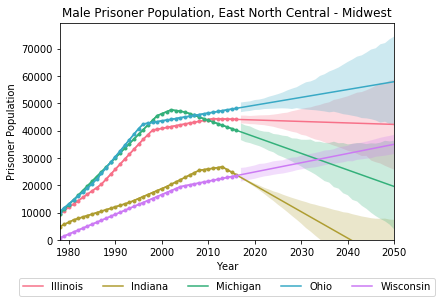

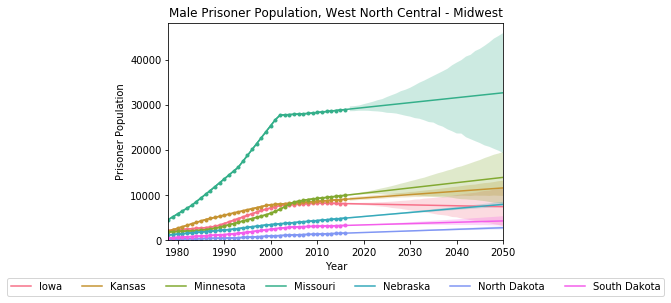

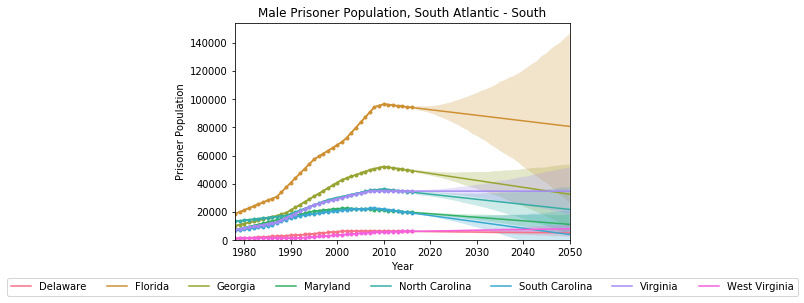

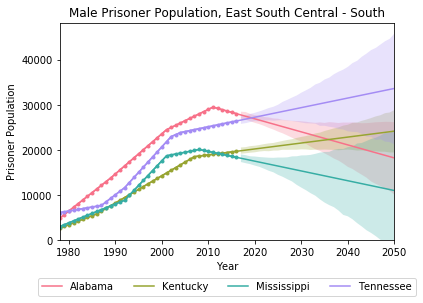

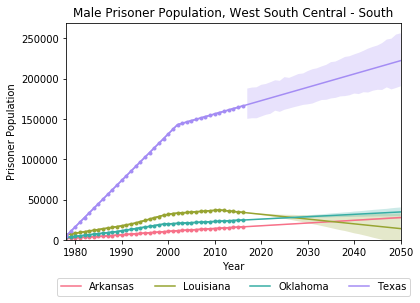

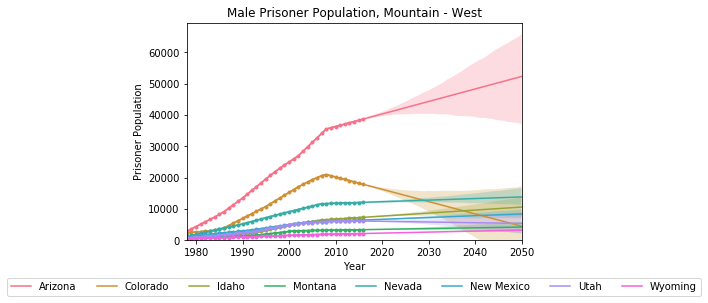

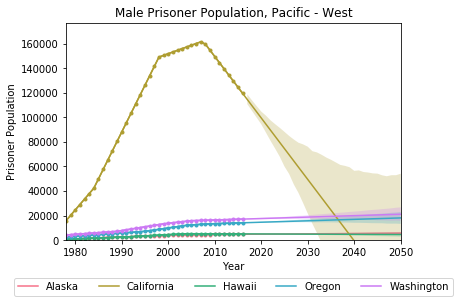

In [28]:
plotStates(predictedMalePrisonerPopulation, 'Male')

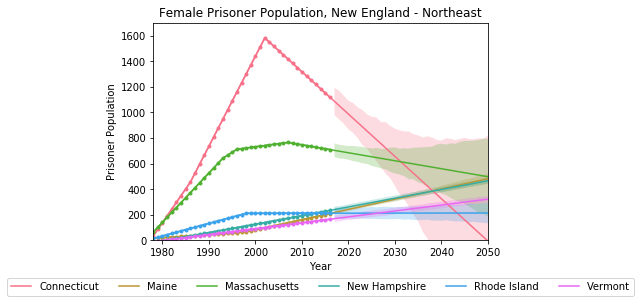

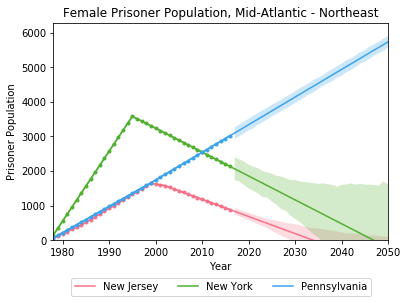

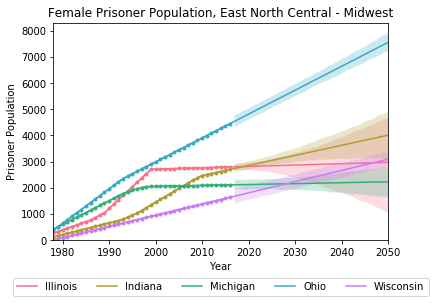

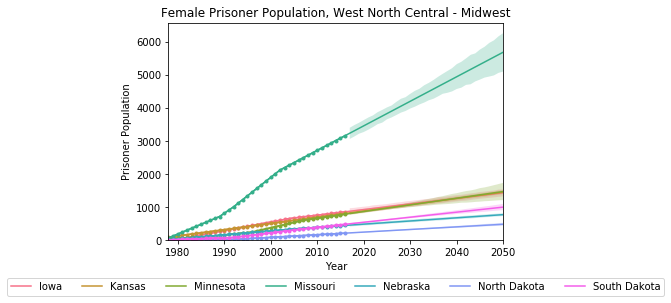

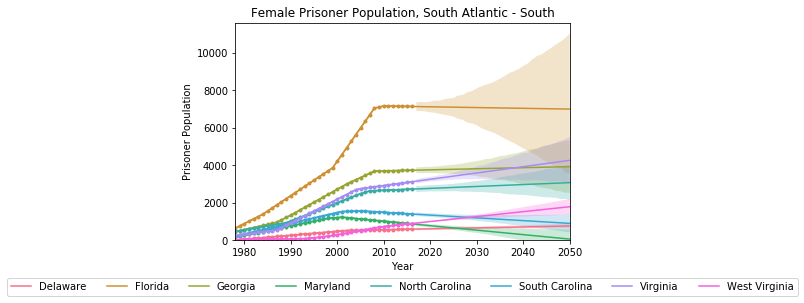

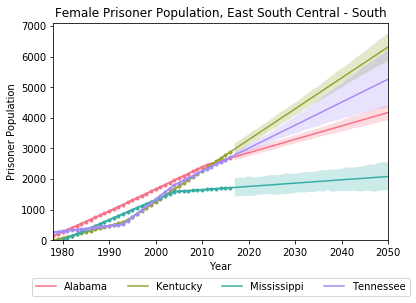

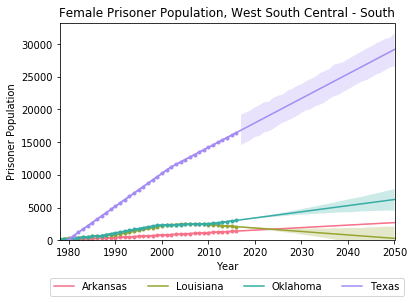

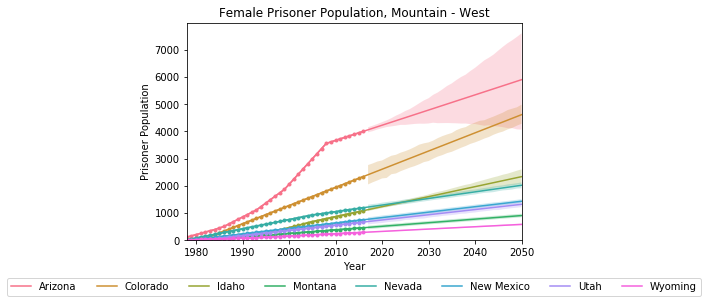

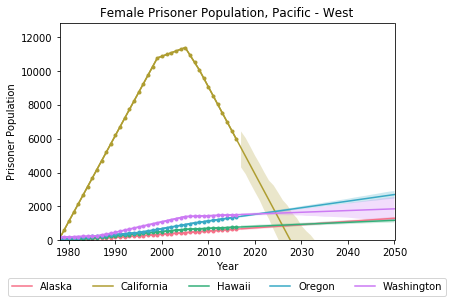

In [29]:
plotStates(predictedFemalePrisonerPopulation, 'Female')

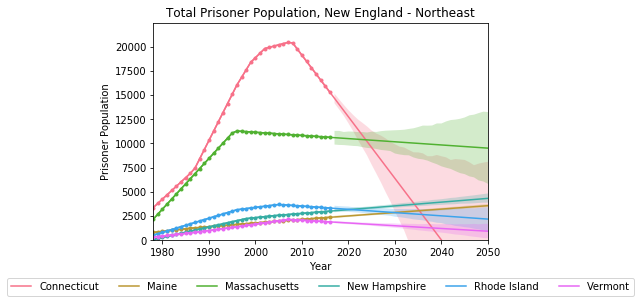

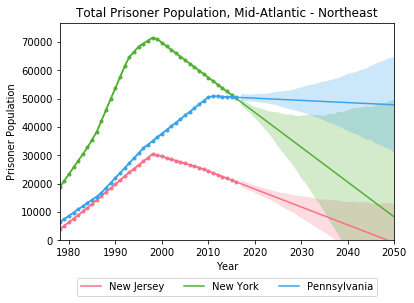

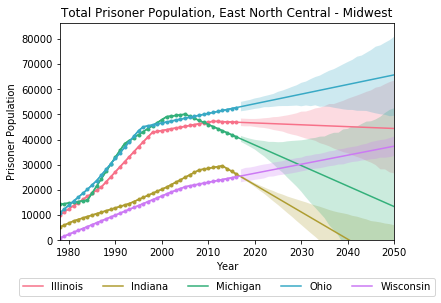

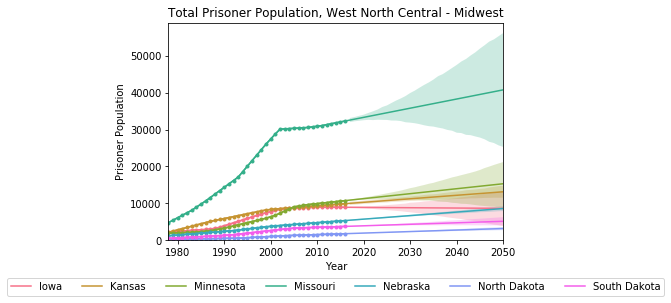

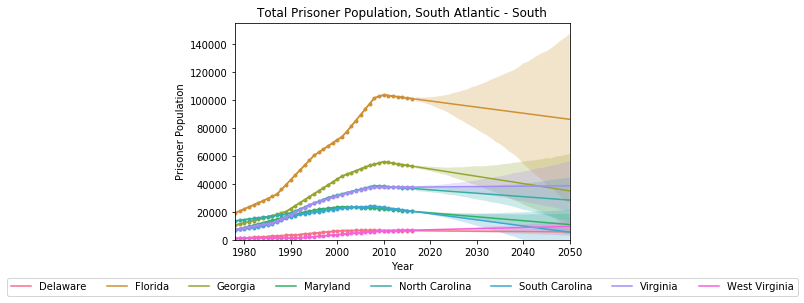

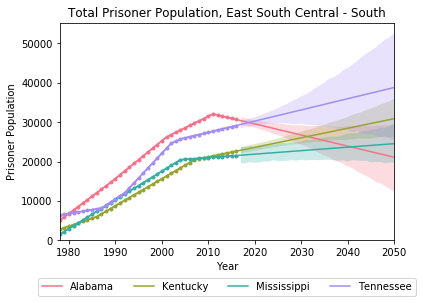

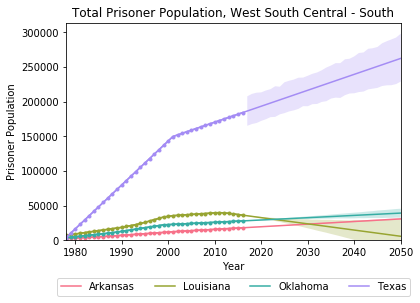

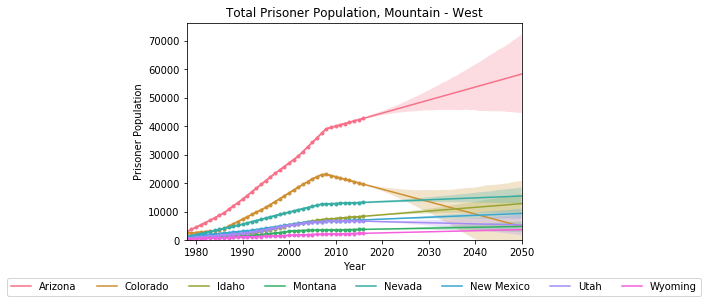

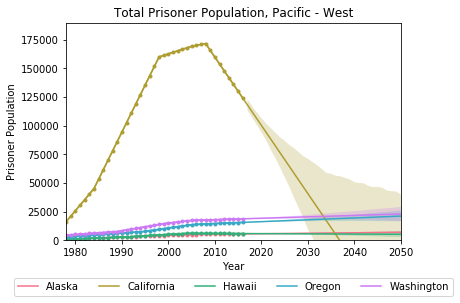

In [30]:
plotStates(predictedTotalPrisonerPopulation, 'Total')

In [18]:
def plotRegions(table, gender):
    
    allRegions = table.Region.unique()

    plt.figure()
    colors = sns.color_palette('husl', n_colors=len(allRegions))
    
    for i, r in enumerate(allRegions):            
        data_1region = table.loc[table.Region == r, :]
            
                
        years_original = data_1region.Year[~ data_1region.Predicted]
        years_predicted = data_1region.Year[data_1region.Predicted]
                
        datapoint_original = data_1region.Population[~ data_1region.Predicted]
        datapoint_predicted = data_1region.Population[data_1region.Predicted]
                
        predictionUpper = data_1region.Upper[data_1region.Predicted]
        predictionLower = data_1region.Lower[data_1region.Predicted]
                
        plt.plot(data_1region.Year, data_1region.Population, color=colors[i],label=r)
        plt.plot(years_original, datapoint_original, marker='.',color=colors[i])
        plt.fill_between(years_predicted, predictionLower,predictionUpper, facecolor=colors[i],linewidth=0,alpha=0.25)
                
    plt.gca().set_ylim(bottom=0, auto=True)
                
    plt.xlabel('Year')
    plt.ylabel('Prisoner Population')
                
    plt.title(gender + 'Regional Prisoner Population')
                
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(states))

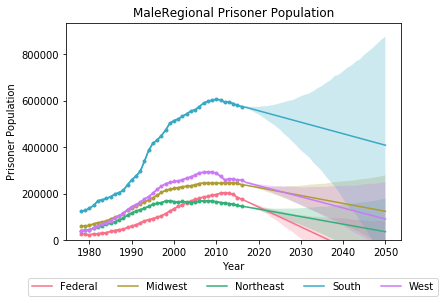

In [19]:
plotRegions(predictedMalePrisonerPopulationRegionSum, 'Male')

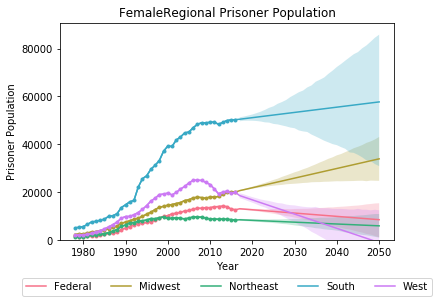

In [20]:
plotRegions(predictedFemalePrisonerPopulationRegionSum, 'Female')

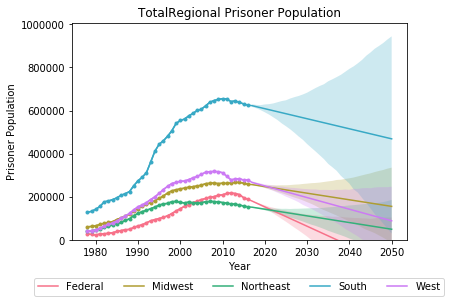

In [21]:
plotRegions(predictedTotalPrisonerPopulationRegionSum, 'Total')

In [22]:
def plotDivisions(table, gender):
    
    table = table.query('Region != "Federal"')

    allRegions = regions.Region.unique()
    for r in allRegions:
        divisions = regions.Division[regions.Region == r].unique()
        data_1region = table.loc[table.Region == r, :]
        
        plt.figure()
        colors = sns.color_palette('husl', n_colors=len(divisions))
        
        for i, d in enumerate(divisions):
            data_1division = data_1region.loc[data_1region.Division == d, :]
            
            data_1division = data_1division.loc[data_1division.Division == d, :]
                
            years_original = data_1division.Year[~ data_1division.Predicted]
            years_predicted = data_1division.Year[data_1division.Predicted]
                
            datapoint_original = data_1division.Population[~ data_1division.Predicted]
            datapoint_predicted = data_1division.Population[data_1division.Predicted]
                
            predictionUpper = data_1division.Upper[data_1division.Predicted]
            predictionLower = data_1division.Lower[data_1division.Predicted]
                
            plt.plot(data_1division.Year, data_1division.Population, color=colors[i],label=d)
            plt.plot(years_original, datapoint_original, marker='.',color=colors[i])
            plt.fill_between(years_predicted, predictionLower,predictionUpper, facecolor=colors[i],linewidth=0,alpha=0.25)
                
        plt.gca().set_ylim(bottom=0, auto=True)
                
        plt.xlabel('Year')
        plt.ylabel('Prisoner Population')
                
        plt.title(gender + 'Divisional Prisoner Population, ' + r)
                
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(states))

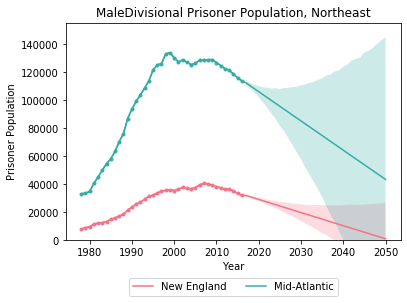

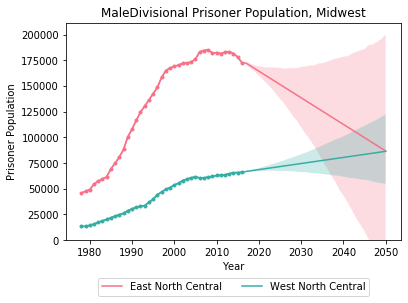

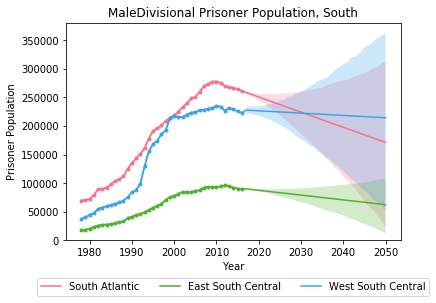

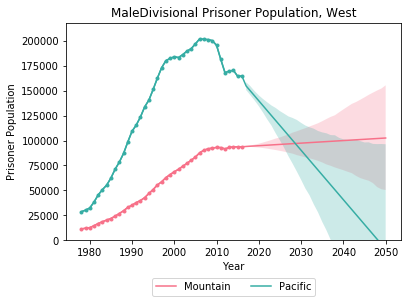

In [23]:
plotDivisions(predictedMalePrisonerPopulationDivisionSum, 'Male')

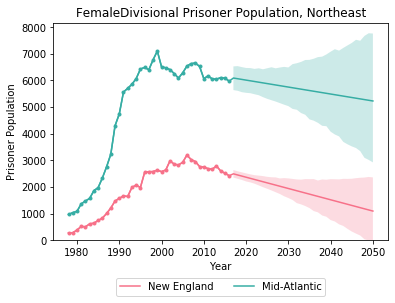

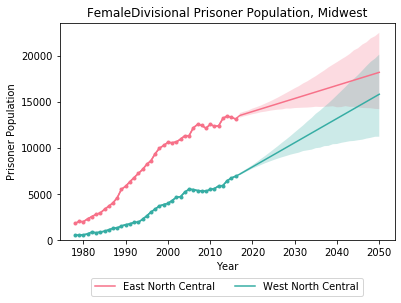

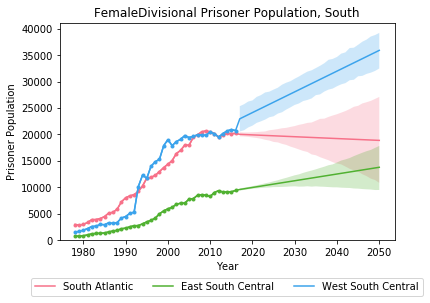

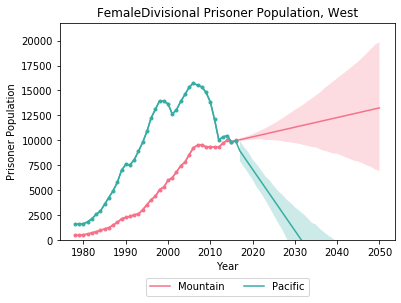

In [24]:
plotDivisions(predictedFemalePrisonerPopulationDivisionSum, 'Female')

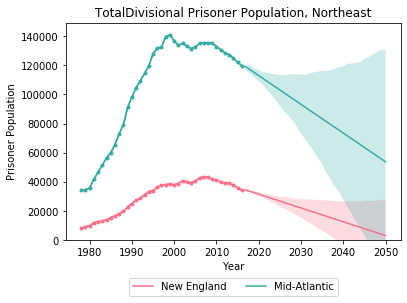

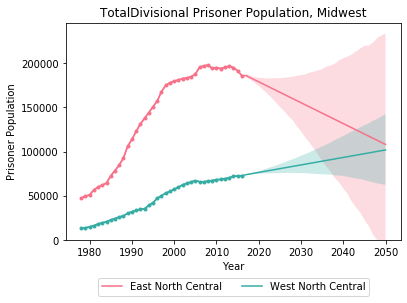

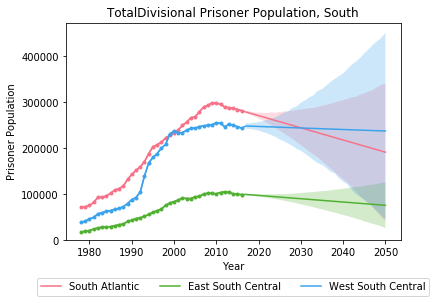

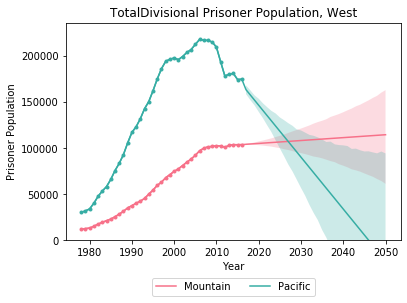

In [25]:
plotDivisions(predictedTotalPrisonerPopulationDivisionSum, 'Total')

In [26]:
predictedMalePrisonerPopulation.query('Jurisdiction == "Kentucky"')

,Jurisdiction,Jurisdiction Abbreviation,Year,Population,Lower,Upper,Predicted
0,Kentucky,KY,1978,2644.048618,1946.007358,3328.229080,False
1,Kentucky,KY,1979,3042.802935,2388.176776,3814.649377,False
2,Kentucky,KY,1980,3442.649729,2763.350776,4174.761470,False
3,Kentucky,KY,1981,3841.404047,3169.272904,4551.490470,False
4,Kentucky,KY,1982,4240.326238,3618.440876,4924.684241,False
5,Kentucky,KY,1983,4639.248429,3839.264483,5343.022999,False
6,Kentucky,KY,1984,5039.688987,4384.668659,5746.171052,False
7,Kentucky,KY,1985,5439.866097,4745.235191,6142.264264,False
8,Kentucky,KY,1986,5840.043207,5148.958955,6570.549817,False
9,Kentucky,KY,1987,6444.515567,5771.923191,7147.172541,False
